# Install dependencies

In [ ]:
!sudo apt-get install tesseract-ocr
!pip -q install pytesseract

In [ ]:
!pip install easyocr

In [ ]:
!pip -q install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 44.4 MB/s eta 0:00:00


In [ ]:
!pip -q install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00


In [ ]:
!pip -q install pillow transformers torch openpyxl

# Rough

In [ ]:
import os
os.chdir('/content/drive/MyDrive/invoice data extraction/')

In [ ]:
os.listdir()

['train1',
 'ghega-dataset',
 'structured_data',
 'train2',
 'train3',
 'temp_preprocessed_image.png',
 'main.ipynb']

In [ ]:
#import zipfile

In [ ]:
#with zipfile.ZipFile('/content/drive/MyDrive/invoice data extraction/train3.zip','r') as zipf:
#  zipf.extractall('/content/drive/MyDrive/invoice data extraction/train3')

In [ ]:
from PIL import Image
import os
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, RagRetriever, RagTokenForGeneration
from datasets import Dataset
import cv2
import numpy as np

# Data Processing

In [ ]:
#paths
image_dir_r = 'train2/train/receipt'
image_dir_i = 'train2/train/invoice'
output_dir = 'structured_data/invoice'  # Directory to save structured Excel files
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

file_count_i = count_files_in_directory(image_dir_i)
file_count_r = count_files_in_directory(image_dir_r)
print(f"Number of invoice images: {file_count_i}")
print(f"Number of invoice receipt: {file_count_r}")

Number of invoice images: 625
Number of invoice receipt: 633


## Image Processing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image at path: {image_path}")
        return None

    #Normalize
    norm_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    #Convert to grayscale
    gray = cv2.cvtColor(norm_img, cv2.COLOR_BGR2GRAY)
    #scaling
    dpi_scaling_factor = 400 /72
    scaled = cv2.resize(gray, None, fx=dpi_scaling_factor, fy=dpi_scaling_factor, interpolation=cv2.INTER_CUBIC)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    grayn = clahe.apply(scaled)
    kernel = np.ones((2, 2), np.uint8)  # small kernel for minimal effect
    noise_removed = cv2.morphologyEx(grayn, cv2.MORPH_OPEN, kernel, iterations=1)

    return noise_removed


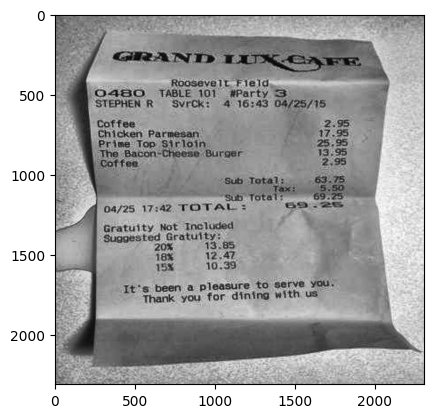

In [ ]:
preprocessed_image = preprocess_image('train2/train/receipt/1001-receipt_jpg.rf.489e8d8aeec33bec224771404738468e.jpg')

plt.imshow(preprocessed_image, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()

## Test extraction

### pytesseract

In [ ]:
# Text extraction from images using pytesseract
"""
def extract_text_from_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
    extracted_data = []
    count = 0
    for image_file in image_files:
        print(image_file)
        image_path = os.path.join(image_dir, image_file)
        preprocessed_image = preprocess_image(image_path)
        preprocessed_pil_image = Image.fromarray(preprocessed_image)
        text = pytesseract.image_to_string(preprocessed_pil_image, lang='eng').strip()
        extracted_data.append({'image_file': image_file, 'text': text})
        count+=1
        if count==5:
          break
    return extracted_data
"""

#ext2 = extract_text_from_images(image_dir)

### Easyocr

In [ ]:
import easyocr

In [ ]:
def extract_text_from_images_using_easyocr(image_dir):
    # Initialize the EasyOCR reader
    reader = easyocr.Reader(['en'])  # Specify the language(s) you want to use
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
    extracted_data = []
    #count = 0
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        preprocessed_img = preprocess_image(image_path)
        temp_image_path = 'temp_preprocessed_image.png'
        cv2.imwrite(temp_image_path, preprocessed_img)
        #img = preprocessed_img
        # Use EasyOCR to extract text from the image
        results = reader.readtext(temp_image_path)
        # Combine the text from the results
        text = " ".join([result[1] for result in results])
        extracted_data.append({'image_file': image_file, 'text': text})
        #count+=1
        #if count==5:
        #  break
    return extracted_data


In [ ]:
#sample extraction text
ext = extract_text_from_images_using_easyocr(image_dir)
ext

[{'image_file': '1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg',
  'text': 'GFEEN F IelO air Jn fte 3ne] Jh LA M4IHETA[ Fc Jd 44148at, Sou Sntyai DMcit Iii In cle !0uz _ Ea!Lh" Tiure 2 dbI2 I1 [ 0C Coitaa 45 90 Jaraehe 00 Cuko T] gu SUD Mliat J 60 Tor S TOTM 66.58 "eutcoib T" JTh JHAK Yov (as'},
 {'image_file': '1000-receipt_jpg.rf.b17cbc08490974652c2d9086e1e50dca.jpg',
  'text': 'Ra GrEEN Field ur\' Fal Une Lata Mel lu  AJatiteh u"96 ilal Ked ilal Tor1 t 1S In 344 13 ! 44e" Fiacli VIjar Raun MI d0 90 Cu]iOr 00 Cult Viu N,60 3l0   1oIal Jax 556.5 TOTAL : Je Ju YA 5726t,"016 THANI NOD ! Lus afltitil Anic Maa bic Junch'},
 {'image_file': '1001-receipt_jpg.rf.109e88972a60051c211342c57973d540.jpg',
  'text': 'DRANI? TITX EStt2 Iefd 9 JI 04125/15 Stephen R 8otiteen Pe5 0 Pr inc Too ~Eutoue Burder ha Jec 8o 4 5 Al JA Nol I2 Gi 13,85 4 4T Hlr IV.3J 4 I0 Aal 4 been (or It Honseven1 party Table 76.43 04b0 SviCk: Faran Siroin eacon Toral: Cotr Hasa Torat 4s Ai! At; Jzs Alecae6] atut G

## Text processing


In [ ]:
import re

def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text).strip()
    # Remove all characters except alphanumeric, '.', ',', ':', and spaces
    text = re.sub(r'[^a-zA-Z0-9.,: ]', '', text)
    text = text.lower()

    return text

In [ ]:
#sample preprocessed text
l = []
for sent in ext:
  l.append(preprocess_text(sent['text']))
l

['gaeen fleld t cacif coas wvn lno daach unnnu ano 590906 stulion suyni jce dnr 0t os 64974 lueet  table 4540 wacn coka sud iqal: tox total : 456.50 5262016 12.:i0 fh hank you  ued',
 'gheen fleld, muy pacif 4manu kon booch 701406 562 597 au stel 0uicu dvni gueglu taba unch coln suo ioiai 556.58 total: i2 j i0 fh 5262016 ihahk you coas jju, 64424',
 'grand jeste: 101 party table 2.95 17.95 25.92 cof fee 13195 chicken pri0e top burper tha eacon 42r cott subs 8 0425 uderd not inc grateated 13.83 t07 ft vqu t0 seriel tor jinino tthank tieid roosevee 042515 40:43 0480 svrc: stepher patuesun sirlain cngeie terala a htata f sub tota 4742 gralu: suqoar pleasure hith been you',
 'grann ixte t field 10 rar43 0472515 stephen srck: 25.95 coffed pariasan 13.95 chicketo sirloin racoi cheuze cottee total 63. sub 144: 69.25 hrota 87 al 13.86 187 you: nith deenyou for rodseve table 46t43 0480 burpat jme aut tote 1747 0475 included not gratuity gretultye suaoeeted 701 eerve basure dinino tnank',
 'gant

# GPT 2

In [ ]:
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
# Initialize GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
def generate_table_from_text(extracted_text):
    # Prepare the prompt
    prompt = "Give title and construct table with the following data as JSON:\n" + extracted_text

    # Tokenize and generate text using GPT-2
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(inputs['input_ids'], max_length=1024, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)

    print("prompt given..")
    # Decode the output and extract the JSON
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print("text generated by gpt..")
    try:
        print("structuring text..")
        json_start = generated_text.index('{')
        json_end = generated_text.rindex('}') + 1
        json_data = generated_text[json_start:json_end]
        table_data = json.loads(json_data)  # Convert JSON text to Python dict
    except (ValueError, json.JSONDecodeError):
        print("Error: Generated text does not contain valid JSON.")
        return None

    return table_data


In [ ]:
def save_json_as_csv(table_data, output_file):
    if table_data:
        df = pd.DataFrame(table_data)  # Convert JSON dict to pandas DataFrame
        df.to_csv(output_file, index=False)  # Save DataFrame to CSV
        print(f"Saved structured data to {output_file}")

In [ ]:

print("Extracting text from images...")
extracted_data = [{'image_file': '1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg',
  'text': 'GAEEN Fleld T CaciF COas WVN L"no Daach unnnu ano 59(-0906 stulion SuynI Jc!e Dnr 0t os 64974 lueet & Table 45-40 Wacn Coka SuD IQAL: Tox ~ToTal : 456.50 5/26/2016 12.:i0 Fh [HANK\' You ! Ued'}]# extract_text_from_images(image_dir)

print("Processing extracted data with GPT-2 to generate tables...")
for data in extracted_data:
  extracted_text = data['text']
  image_file = data['image_file']

  # Generate structured table as JSON
  table_data = generate_table_from_text(extracted_text)
  print(table_data)
  break

  #if table_data:
  #  output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}.csv")
  #  save_json_as_csv(table_data, output_path)

'\nprint("Extracting text from images...")\nextracted_data = [{\'image_file\': \'1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg\',\n  \'text\': \'GAEEN Fleld T CaciF COas WVN L"no Daach unnnu ano 59(-0906 stulion SuynI Jc!e Dnr 0t os 64974 lueet & Table 45-40 Wacn Coka SuD IQAL: Tox ~ToTal : 456.50 5/26/2016 12.:i0 Fh [HANK\' You ! Ued\'}]# extract_text_from_images(image_dir)\n\nprint("Processing extracted data with GPT-2 to generate tables...")\nfor data in extracted_data:\n  extracted_text = data[\'text\']\n  image_file = data[\'image_file\']\n\n  # Generate structured table as JSON\n  table_data = generate_table_from_text(extracted_text)\n  print(table_data)\n  break\n'

# GPT 4 pipeline

In [ ]:
from transformers import pipeline

In [ ]:
gpt_pipeline = pipeline("text-generation", model="nomic-ai/gpt4all-j")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
input_text = "GANTD LTX C3FE RooseveIL Fleld 0480 TABLE 101 #Party STEPHEN SvrCk : \'16:43 04/25/15 Coffee 13.95 Chicken Parmesan Prime rioin 25.95 The Bacon Chelain Burger 13.95 Cotfee Subi Total: 63.75 Tax: Sub Total {69.25 04/25 17;47 TOTAL 6 18 Gratuity Not-Included Suguested Gratuity 203 13.85 18* 12.47 451 been pleasure tO serve You Thank You for dining with Us'}"
prompt = f"Give title to the table and construct a table with the following data, and return the table as JSON:\n\n{input_text}"

response = gpt_pipeline(prompt, max_length=1024, num_return_sequences=1)[0]['generated_text']

response

In [ ]:
def fine_tune_gpt4(extracted_data):
    # Initialize GPT-4 model pipeline (using text generation model from Hugging Face)
    gpt_pipeline = pipeline("text-generation", model="nomic-ai/gpt4all-j")

    structured_data = []

    for data in extracted_data:
        input_text = data['text']
        # Formulate the prompt for table generation
        prompt = f"Give title to the table and construct a table with the following data, and return the table as JSON:\n\n{input_text}"

        # Generate table as JSON using the model
        response = gpt_pipeline(prompt, max_length=1024, num_return_sequences=1)[0]['generated_text']

        structured_data.append({'image_file': data['image_file'], 'structured_json': response})

    return structured_data

In [ ]:
def json_to_csv_and_save(structured_data):
    for data in structured_data:
        json_text = data['structured_json']

        try:
            # Convert the JSON text into a DataFrame
            df = pd.read_json(json_text)

            # Save DataFrame to CSV
            output_path = os.path.join(output_dir, f"{os.path.splitext(data['image_file'])[0]}.csv")
            df.to_csv(output_path, index=False)
            print(f"Saved {output_path}")
        except ValueError:
            print(f"Failed to process JSON for {data['image_file']}")


In [ ]:
print("Extracting text from images...")
extracted_data = extract_text_from_images(image_dir)

Extracting text from images...


In [ ]:
extracted_data

[{'image_file': '1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg',
  'text': '3.00\n45 90\n3.00\n\n5190\n060\n\n   \n\n5/26/2016 12-53-10 PM\n\nTHANK You!\n\neee'},
 {'image_file': '1000-receipt_jpg.rf.b17cbc08490974652c2d9086e1e50dca.jpg',
  'text': ''},
 {'image_file': '1001-receipt_jpg.rf.109e88972a60051c211342c57973d540.jpg',
  'text': 'ol\n\nGaRAnNrP Ke\n\npocesvelt heie\nqaeve 100 Sharky\na v8:43\n\nyee\n\nas2s/\n\n   \n \n\n048°\nSTEPHEN F\n\ncoffee\nCotten parses\nOne Top SNTlON\nBr 1s gcon-cneese Pe\ncarter\n\neae'},
 {'image_file': '1001-receipt_jpg.rf.324f4e0a4f5c9ef2a0a2a6857e6c7b51.jpg',
  'text': 'i.\n\nGrRanpPt aK\n\nevelt Feld\n\n \n\n \n\n \n\n \n\n \n\nRoost\naso THEI Mera\nOs R sce: 4 fares 04/25/19\ncoffee. 2.98\nCotten Parmesan 17.38\nCheon sir torn 23.35\nPrime ron cheese Surge 13\ntotfee 2\na totals, 3168\nee\nEen. se\na your" ©\ngravutty Wot SRT\naCe AE\npes. pean 2 PISA to serve YU"\nPleasiining with YS\n\n————'},
 {'image_file': '1001-receipt_jpg.rf.4

In [ ]:
print("Generating structured table using GPT-4...")
structured_data = fine_tune_gpt4(extracted_data)

Generating structured table using GPT-4...


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print("Saving structured data to CSV files...")
json_to_csv_and_save(structured_data)
print("Process completed!")

# GPT4All


In [ ]:
!pip -q install gpt4all

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00


In [ ]:
from gpt4all import GPT4All
model = GPT4All("Meta-Llama-3-8B-Instruct.Q4_0.gguf")

Downloading: 100%|██████████| 4.66G/4.66G [02:11<00:00, 35.5MiB/s]
Verifying: 100%|██████████| 4.66G/4.66G [00:16<00:00, 288MiB/s]


In [ ]:
tex = "GANTD LTX C3FE RooseveIL Fleld 0480 TABLE 101 #Party STEPHEN SvrCk : \'16:43 04/25/15 Coffee 13.95 Chicken Parmesan Prime rioin 25.95 The Bacon Chelain Burger 13.95 Cotfee Subi Total: 63.75 Tax: Sub Total 69.25 04/25 17;47 TOTAL 6 18 Gratuity Not-Included Suguested Gratuity 203 13.85 18* 12.47 451 been pleasure tO serve You Thank You for dining with Us. /n the above text is a invoice bill text extracted using EasyOCR, convert this into to a table and return the table as JSON"

In [ ]:
#sample generation
with model.chat_session():
    print(model.generate(tex, max_tokens=1024))

Here is the converted table in JSON format:

```
{
    "columns": [
        {
            "name": "Item",
            "values": ["GANTD LTX C3FE RooseveIL Fleld 0480 TABLE", "Coffee", "Chicken Parmesan Prime rioin", "The Bacon Chelain Burger", "Cotfee Subi"]
        },
        {
            "name": "Price",
            "values": ["13.95", "25.95", "13.95", "", "12.47"]
        }
    ],
    "data": [
        [GANTD LTX C3FE RooseveIL Fleld 0480 TABLE, 13.95],
        [Coffee, 13.95],
        [Chicken Parmesan Prime rioin, 25.95],
        [The Bacon Chelain Burger, 13.95],
        [Cotfee Subi, 12.47]
    ]
}
```

Note that I had to make some assumptions about the table structure and data based on the provided text. Specifically:

* The first column is assumed to be "Item" with values being the names of menu items.
* The second column is assumed to be "Price" with values being the prices of each item (except for the last row, which appears to be a subtotal or total).
* I did not include 

In [ ]:

def fine_tune_gpt4all(extracted_data):
    structured_data = []

    for data in extracted_data:
        # Define the prompt for GPT-4All
        prompt = f"Give title to the table and construct table with the following data: {data}. Return the table as JSON."

        # Generate the table in JSON format
        with model.chat_session():
          response = model.generate(prompt, max_tokens=1024)

        generated_json = response['choices'][0]['message']['content']

        structured_data.append({
            'image_file': data['image_file'],
            'json_table': generated_json
        })

    return structured_data

In [ ]:
# Step 3: Convert the structured JSON to CSV and save
def save_to_csv(structured_data):
    for data in structured_data:
        json_table = data['json_table']
        image_file = data['image_file']

        # Convert JSON table to a pandas DataFrame
        df = pd.read_json(json_table)

        # Save DataFrame to CSV
        output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}.csv")
        df.to_csv(output_path, index=False)

In [ ]:
print("Extracting text from images...")
extracted_data = extract_text_from_images(image_dir)

Extracting text from images...


In [ ]:
print("Generating structured tables using GPT-4All...")
structured_data = fine_tune_gpt4all(extracted_data)

Generating structured tables using GPT-4All...


In [ ]:
print("Saving structured tables to CSV files...")
save_to_csv(structured_data)
print("Process completed!")